# NetworkX Graph to CSV file

In [1]:
#Graph to csv
import torch
from collections import defaultdict
import torch_geometric
import numpy as np
from torch_geometric.data import Data
import networkx as nx
import numpy as np
import pandas as pd
import random
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler
from torch_geometric.data import InMemoryDataset, Data
import torch.nn.functional as f
from torch.utils.data import random_split

class DatasetCreation():
    def __init__(self):

        if torch.cuda.is_available():            
            self.device = "cuda:3"
            print("Device is: ",self.device)
        else:
            self.device = "cpu"
        self.device = "cpu"

    def GraphtoCSV(self, name, Normalize=None, Weights=None):
        G = nx.read_gpickle(name)
        print("Total Nodes:",G.number_of_nodes())
        G = nx.convert_node_labels_to_integers(G)
        G = G.to_directed() if not nx.is_directed(G) else G
        edge_index = torch.LongTensor(list(G.edges)).t().contiguous() #'userID','screen_name',    
        group_node_attrs = ['followers_count', 'friends_count', 'listed_count', 'acc_created_at',
                            'favourites_count', 'verified', 'Tweets',
                            'followerPerDay', 'statusPerDay', 'favPerTweet', 'friendsPerDay', 'followFriends',
                            'friendNlisted','prot','foPerTweet','frPerTweet','favPerFollow','favPerFriend','listPerDay','Exists']
        data = defaultdict(list)
        group_edge_attrs=None
        if G.number_of_nodes() > 0:
            node_attrs = list(next(iter(G.nodes(data=True)))[-1].keys())
            print("The orignal node attributes", node_attrs)
        else:
            node_attrs = {}

        if G.number_of_edges() > 0:
            edge_attrs = list(next(iter(G.edges(data=True)))[-1].keys())
        else:
            print("No edge attributes")
            edge_attrs = {}

        for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
            if set(feat_dict.keys()) != set(node_attrs):
                raise ValueError('Not all nodes contain the same attributes')
            for key, value in feat_dict.items():
                # print(key,value)
                data[str(key)].append(value)

        for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
            if set(feat_dict.keys()) != set(edge_attrs):
                raise ValueError('Not all edges contain the same attributes')
            for key, value in feat_dict.items():
                data[str(key)].append(value)
        for key, value in data.items():
            try:
                data[key] = torch.tensor(value)
            except ValueError:
                pass
        data = torch_geometric.data.Data.from_dict(data)
        x_np = np.empty((len(G.nodes), len(node_attrs)), dtype=float)
        i = 0
        for n in G.nodes:
            onenode = []
            for a in node_attrs:
                # print(Gp.nodes[n][a])
                onenode.append(G.nodes[n][a])
            # print(onenode)
            x_np[i] = onenode
            i = i + 1       
        data.x = torch.from_numpy(x_np)  # numpy to torch
        temp= data.x.select(1,13)#[7:7]
        temp_np=temp.detach().numpy()
        data.y=torch.from_numpy(temp_np).float()
        data=data.to(self.device)
        data.x=data.x.to(self.device)
        if data.x is None:
            data.num_nodes = G.number_of_nodes()
        if group_node_attrs is all:
            group_node_attrs = list(node_attrs)
        if group_node_attrs is not None:
            xs = [data[key] for key in group_node_attrs]
            xs = [x.view(-1, 1) if x.dim() <= 1 else x for x in xs]
            data.x = torch.cat(xs, dim=-1)
        data.num_classes = 2
        if group_edge_attrs is all:
            group_edge_attrs = list(edge_attrs)
        if group_edge_attrs is not None:
            edge_attrs = [data[key] for key in group_edge_attrs]
            edge_attrs = [x.view(-1, 1) if x.dim() <= 1 else x for x in edge_attrs]
            data.edge_attr = torch.cat(edge_attrs, dim=-1).float()
            print("data edge_attr is using", data.edge_attr.get_device())
        if Normalize == True:
            # Data
            print("Data is Normalized")
            transformer = MaxAbsScaler().fit(x_np)
            newdf = transformer.transform(x_np)
            import pandas as pd
            px = pd.DataFrame(newdf)#'userID','screen_name',
            px.columns = ['followers_count', 'friends_count', 'listed_count', 'acc_created_at',
                            'favourites_count', 'verified', 'Tweets',
                            'followerPerDay', 'statusPerDay', 'favPerTweet', 'friendsPerDay', 'followFriends',
                            'friendNlisted','prot','foPerTweet','frPerTweet','favPerFollow','favPerFriend','listPerDay','y']
            px.to_csv("CSVFiles/IASC AllUsers Normalized.csv", index=False)
            data.x = torch.from_numpy(newdf).float()
        else: 
            import pandas as pd
            px = pd.DataFrame(x_np)#'userID','screen_name',
            px.columns = ['followers_count', 'friends_count', 'listed_count', 'acc_created_at',
                                'favourites_count', 'verified', 'Tweets',
                                'followerPerDay', 'statusPerDay', 'favPerTweet', 'friendsPerDay', 'followFriends',
                                'friendNlisted','prot','foPerTweet','frPerTweet','favPerFollow','favPerFriend','listPerDay','y']
            px.to_csv("CSVFiles/IASC AllUsers.csv", index=False)   
        print("CSVFiles/IASC AllUsers.csv created")


obj = DatasetCreation()
obj.GraphtoCSV(name='CSVFiles/AllUsersGraph.gpickle' ,Normalize=False)#, Weights=True)


Device is:  cuda:3
Total Nodes: 1292399
The orignal node attributes ['followers_count', 'friends_count', 'listed_count', 'acc_created_at', 'favourites_count', 'verified', 'Tweets', 'followerPerDay', 'statusPerDay', 'favPerTweet', 'friendsPerDay', 'followFriends', 'friendNlisted', 'prot', 'foPerTweet', 'frPerTweet', 'favPerFollow', 'favPerFriend', 'listPerDay', 'Exists']
No edge attributes
CSVFiles/IASC AllUsers.csv created


## Training


### Intilization

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, recall_score, precision_score, jaccard_score, f1_score
from transformers import Trainer
import pandas as pd
import random

In [3]:
def DataSetLoad():    
    AllUsersDataset = pd.read_csv("CSVFiles/IASC AllUsers.csv",index_col=None) 
    print("Total dataset Shape: ",AllUsersDataset.shape)
    return AllUsersDataset

In [4]:
AllUsersDataset= DataSetLoad()
def DataPartition(AllUsersDataset):
    print("Total dataset Shape: ",AllUsersDataset.shape)
    # Seperating Spam (deleted) and Genuine (not deleted) Users
    DeletedUsersDF = AllUsersDataset.loc[AllUsersDataset['y'] == 0] # 0 indicates that user is Spam
    NotDeleted = AllUsersDataset.loc[AllUsersDataset['y'] == 1]  # 1 indicates that user is Genuine
    print('\nDataframe Shape of Spam (Deleted) Users:\n', DeletedUsersDF.shape)
    print('\nDataframe Shape of Genuine (Not Deleted) Users:\n', NotDeleted.shape)
    NotDeleted = shuffle(NotDeleted, random_state=2001) 
    selectedNotDeleted=NotDeleted.sample(n = 211394) # Taking sample random equal number of users as Spam users for training (50% both Spam and Genunie) 
    print('\nDataframe Shape of Genuine (Not Deleted) After sample:\n', NotDeleted.shape) 
    TrainingDataset = pd.concat([DeletedUsersDF,selectedNotDeleted], sort=False)
    print('\nDataframe Shape of Training Dataset:\n', TrainingDataset.shape)
    #TrainingDataset.to_csv("CSVFiles/IASC TrainingData.csv", index=False)  #This Dataset (.csv) is already provided, uncomment this line to save the CSV file
    return  TrainingDataset
TrainingDataset = DataPartition(AllUsersDataset)    
TrainingDataset.head()

Total dataset Shape:  (1292399, 20)
Total dataset Shape:  (1292399, 20)

Dataframe Shape of Spam (Deleted) Users:
 (211394, 20)

Dataframe Shape of Genuine (Not Deleted) Users:
 (1081005, 20)

Dataframe Shape of Genuine (Not Deleted) After sample:
 (1081005, 20)

Dataframe Shape of Training Dataset:
 (422788, 20)


,followers_count,friends_count,listed_count,acc_created_at,favourites_count,verified,Tweets,followerPerDay,statusPerDay,favPerTweet,friendsPerDay,followFriends,friendNlisted,prot,foPerTweet,frPerTweet,favPerFollow,favPerFriend,listPerDay,y
1,19.0,350.0,0.0,689.922616,2113.0,0.0,17343.0,0.027539,25.137602,0.121836,0.507303,0.054286,0.0,0.0,0.001096,0.020181,111.210526,6.037143,0.000000,0.0
3,1000.0,930.0,1.0,1640.113206,365196.0,0.0,24479.0,0.609714,14.925189,14.918747,0.567034,1.075269,930.0,0.0,0.040851,0.037992,365.196000,392.683871,0.000610,0.0
6,788.0,471.0,2.0,415.817326,28796.0,0.0,9571.0,1.895063,23.017319,3.008672,1.132709,1.673036,235.5,0.0,0.082332,0.049211,36.543147,61.138004,0.004810,0.0
19,9.0,30.0,1.0,401.469792,1255.0,0.0,2412.0,0.022418,6.007924,0.520315,0.074725,0.300000,30.0,0.0,0.003731,0.012438,139.444444,41.833333,0.002491,0.0
21,43.0,147.0,0.0,257.099248,232.0,0.0,8829.0,0.167251,34.340824,0.026277,0.571764,0.292517,0.0,0.0,0.004870,0.016650,5.395349,1.578231,0.000000,0.0



Dataframe Shape of Total Training Dataset:
 (422788, 20)
Train Dataset Shape:
 (338230, 19)
Test Dataset Shape:
 (84558, 19)


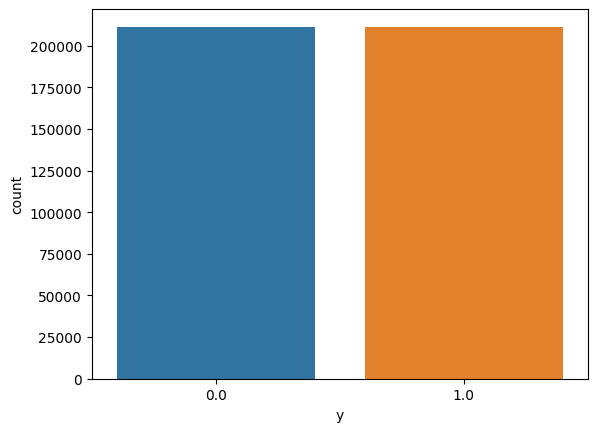

In [5]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, recall_score, precision_score, jaccard_score, f1_score
from transformers import Trainer
import pandas as pd
import random
import time
import os
TrainingDataset=pd.read_csv("CSVFiles/IASC TrainingData.csv")
sns.countplot(x = 'y', data=TrainingDataset)
print('\nDataframe Shape of Total Training Dataset:\n', TrainingDataset.shape)
datasetShuf = shuffle(TrainingDataset, random_state=98567)
X = datasetShuf.iloc[:, 0:-1]
y = datasetShuf.iloc[:, -1]
#print (datasetShuf.shape)
#print (X.shape)
#print (y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10234) # 80% training and 20% testing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#print (type(X))
#print (type(y))
print ('Train Dataset Shape:\n', (X_train.shape))
print ('Test Dataset Shape:\n',X_test.shape)
#print('Sample X_train', X_train[0:1])
#print('Sample X_test',X_test[0:1])

# Notice: 
These results are not average of 20 Runs.
Please refer to .py files to regenerate results

# Decision Trees

Executing:  gini
Results of :  gini
F1_SCORE:  0.7481906246520433  ACCURACY : 0.679060526502519  JaccardScore : 0.5976873471203025  RECALL : 0.953548875381377  PRECISION : 0.6156113053702036


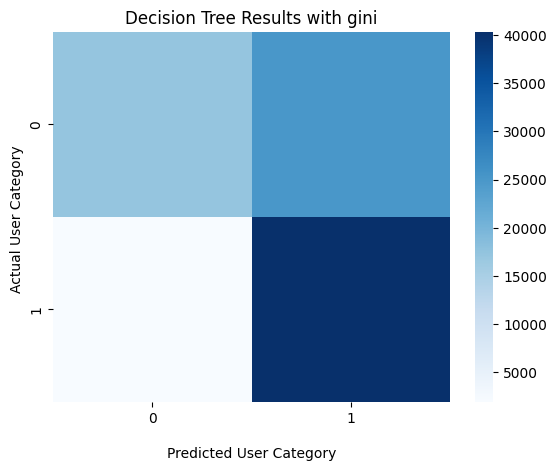

Total Running time = 10.162 seconds  of  gini
Executing:  entropy
Results of :  entropy
F1_SCORE:  0.7476205861989385  ACCURACY : 0.6766834598736962  JaccardScore : 0.596960136808586  RECALL : 0.9577115016201131  PRECISION : 0.6131215553267518


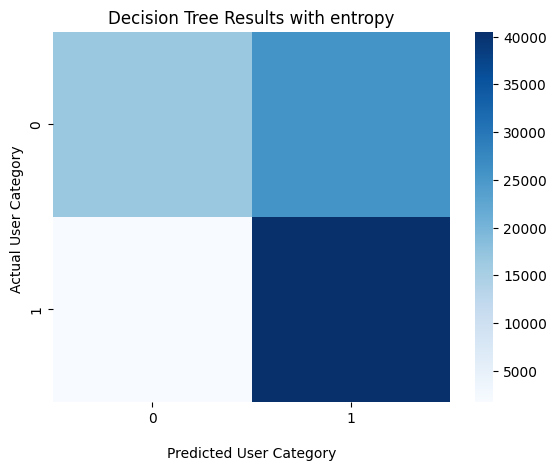

Total Running time = 11.494 seconds  of  entropy
Executing:  log_loss
Results of :  log_loss
F1_SCORE:  0.7476205861989385  ACCURACY : 0.6766834598736962  JaccardScore : 0.596960136808586  RECALL : 0.9577115016201131  PRECISION : 0.6131215553267518


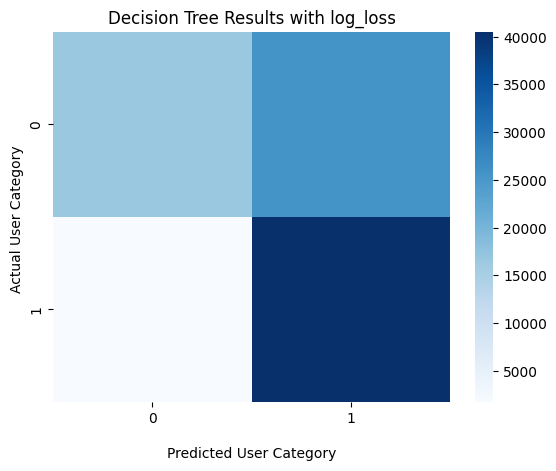

Total Running time = 8.983 seconds  of  log_loss


In [6]:
F1_SCORE= ACCURACY = JaccardScore= RECALL =  PRECISION=0
from sklearn.tree import DecisionTreeClassifier
CRITERIONs=['gini', 'entropy', 'log_loss']
for CRITERION in CRITERIONs:
    print('Executing: ', CRITERION)
    start_time = time.time()    
    MAX_DEPTH=5
    if CRITERION=='gini':
        MAX_DEPTH=6
    classifier= DecisionTreeClassifier(criterion=CRITERION,max_depth=MAX_DEPTH) #{“gini”, “entropy”, “log_loss”},
    classifier.fit(X_train,y_train)
    y_pred_list=classifier.predict(X_test)
    X_train_Pred=classifier.predict(X_train)
    TrainingResult =accuracy_score(y_train,X_train_Pred)
    TestResult =accuracy_score(y_test,y_pred_list)
    F1_SCORE=f1_score(y_test, y_pred_list)#, average='micro')
    ACCURACY=accuracy_score( y_test, y_pred_list)
    JaccardScore=jaccard_score(y_test, y_pred_list,pos_label=1)
    cfM=confusion_matrix(y_test, y_pred_list)
    RECALL=recall_score(y_test, y_pred_list)#, average='micro')
    PRECISION=precision_score(y_test, y_pred_list)#, average='micro') 
    print('Results of : ', CRITERION)
    print('F1_SCORE: ',F1_SCORE,' ACCURACY :',ACCURACY,' JaccardScore :',JaccardScore, ' RECALL :',RECALL, ' PRECISION :',PRECISION)    
    ax = sns.heatmap(cfM, annot=False, cmap='Blues')
    ax.set_title('Decision Tree Results with '+ CRITERION );
    ax.set_xlabel('\nPredicted User Category')
    ax.set_ylabel('Actual User Category ');
    plt.show()
    ex_time=time.time() - start_time
    print("Total Running time = {:.3f} seconds".format(ex_time), " of ", CRITERION)

# Random Forest

Executing:  gini
Results of :  gini
F1_SCORE:  0.7436735419279036  ACCURACY : 0.692979966413586  JaccardScore : 0.5919429119315949  RECALL : 0.8907074099477307  PRECISION : 0.6383050847457628


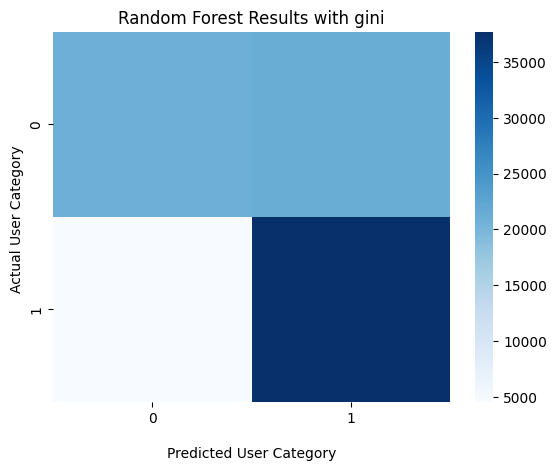

Total Running time = 198.549 seconds  of  gini
Executing:  entropy
Results of :  entropy
F1_SCORE:  0.7433598642877574  ACCURACY : 0.6922703942855791  JaccardScore : 0.5915455373120271  RECALL : 0.8912986920839148  PRECISION : 0.6375401793266791


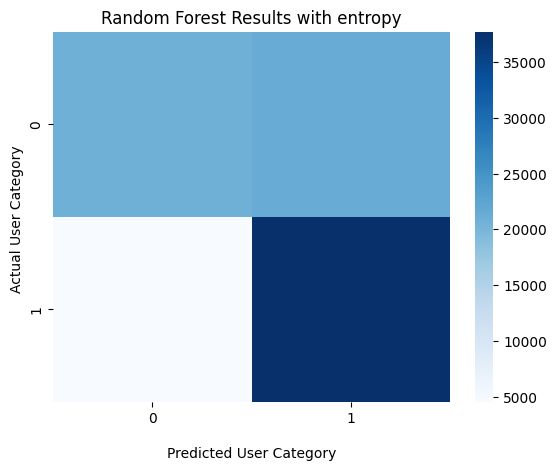

Total Running time = 252.438 seconds  of  entropy
Executing:  log_loss
Results of :  log_loss
F1_SCORE:  0.743517793223801  ACCURACY : 0.6940916294141299  JaccardScore : 0.5917455808080808  RECALL : 0.8867576452780208  PRECISION : 0.6401181451888275


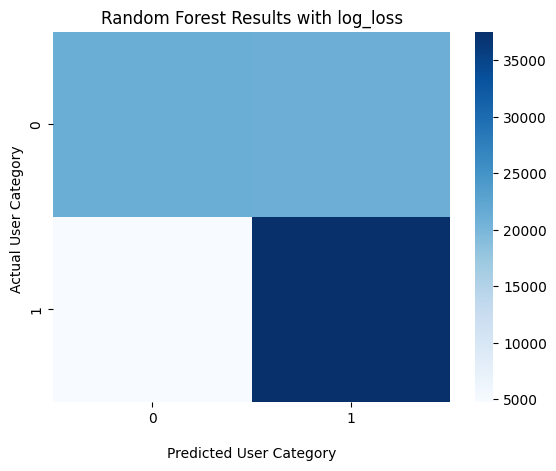

Total Running time = 217.055 seconds  of  log_loss


In [7]:
F1_SCORE= ACCURACY = JaccardScore= RECALL =  PRECISION=0
from  sklearn.ensemble import RandomForestClassifier
import time
Depth=9
CRITERIONs=['gini', 'entropy', 'log_loss']
for CRITERION in CRITERIONs:
    print('Executing: ', CRITERION)
    start_time = time.time()            
    if CRITERION == 'log_loss':
        MAX_DEPTH= 10 
    else: 
        MAX_DEPTH= Depth          
    classifier= RandomForestClassifier(criterion=CRITERION,max_depth=MAX_DEPTH) #{“gini”, “entropy”, “log_loss”},
    classifier.fit(X_train,y_train)
    y_pred_list=classifier.predict(X_test)
    X_train_Pred=classifier.predict(X_train)
    TrainingResult =accuracy_score(y_train,X_train_Pred)
    TestResult =accuracy_score(y_test,y_pred_list)
    F1_SCORE=f1_score(y_test, y_pred_list)#, average='micro')
    ACCURACY=accuracy_score( y_test, y_pred_list)
    JaccardScore=jaccard_score(y_test, y_pred_list,pos_label=1)
    cfM=confusion_matrix(y_test, y_pred_list)
    RECALL=recall_score(y_test, y_pred_list)#, average='micro')
    PRECISION=precision_score(y_test, y_pred_list)#, average='micro')
    print('Results of : ', CRITERION)
    print('F1_SCORE: ',F1_SCORE,' ACCURACY :',ACCURACY,' JaccardScore :',JaccardScore, ' RECALL :',RECALL, ' PRECISION :',PRECISION)    
    ax = sns.heatmap(cfM, annot=False, cmap='Blues')
    ax.set_title('Random Forest Results with '+ CRITERION );
    ax.set_xlabel('\nPredicted User Category')
    ax.set_ylabel('Actual User Category ');
    plt.show()
    ex_time=time.time() - start_time
    print("Total Running time = {:.3f} seconds".format(ex_time), " of ", CRITERION)


# KNN

F1_SCORE:  0.7141256571576317  ACCURACY : 0.686179900186854  JaccardScore : 0.5553619302949062  RECALL : 0.7838982048674346  PRECISION : 0.6557584630908335


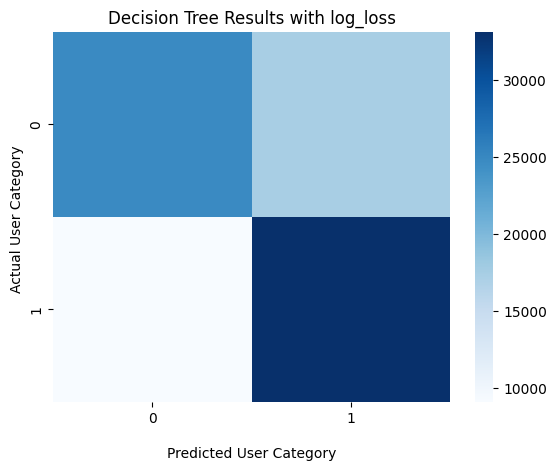

Total Running time = 86.099 seconds


In [8]:
F1_SCORE= ACCURACY = JaccardScore= RECALL =  PRECISION=0
from sklearn.neighbors import KNeighborsClassifier
neighbors=81
start_time = time.time()
#Train Model and Predict  
KNNclassifier = KNeighborsClassifier(n_neighbors = neighbors).fit(X_train,y_train)
y_pred_list=KNNclassifier.predict(X_test)
X_train_Pred=KNNclassifier.predict(X_train)
TrainingResult =accuracy_score(y_train,X_train_Pred)
TestResult =accuracy_score(y_test,y_pred_list)
F1_SCORE=f1_score(y_test, y_pred_list)#, average='micro')
ACCURACY=accuracy_score( y_test, y_pred_list)
JaccardScore=jaccard_score(y_test, y_pred_list,pos_label=1)
cfM=confusion_matrix(y_test, y_pred_list)
RECALL=recall_score(y_test, y_pred_list)#, average='micro')
PRECISION=precision_score(y_test, y_pred_list)#, average='micro')
print('F1_SCORE: ',F1_SCORE,' ACCURACY :',ACCURACY,' JaccardScore :',JaccardScore, ' RECALL :',RECALL, ' PRECISION :',PRECISION)    
ax = sns.heatmap(cfM, annot=False, cmap='Blues')
ax.set_title('Decision Tree Results with '+ CRITERION );
ax.set_xlabel('\nPredicted User Category')
ax.set_ylabel('Actual User Category ');
plt.show()
ex_time=time.time() - start_time
print("Total Running time = {:.3f} seconds".format(ex_time))

# XGB

Executing:  gbtree
Results of :  gbtree
F1_SCORE:  0.7472196111643663  ACCURACY : 0.6787885238534497  JaccardScore : 0.5964490008171756  RECALL : 0.949457202998983  PRECISION : 0.6160078566167444


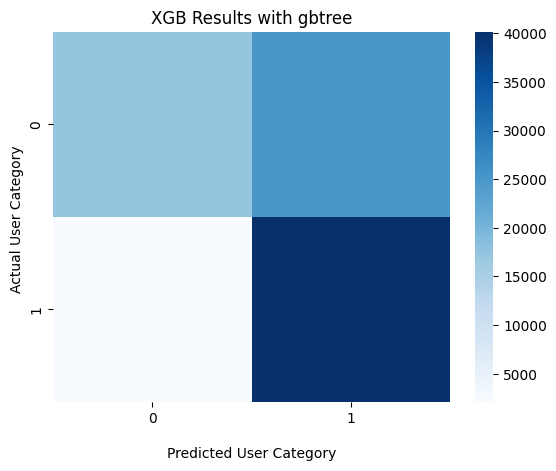

Total Running time = 33.018 seconds  of  gbtree
Executing:  dart
Results of :  dart
F1_SCORE:  0.7472196111643663  ACCURACY : 0.6787885238534497  JaccardScore : 0.5964490008171756  RECALL : 0.949457202998983  PRECISION : 0.6160078566167444


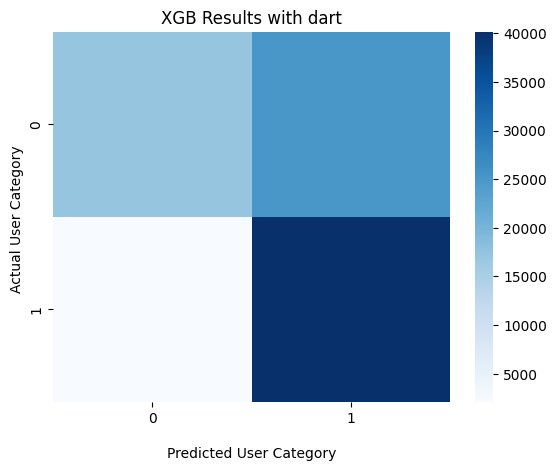

Total Running time = 76.606 seconds  of  dart
Executing:  gblinear
[21:06:45] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

Results of :  gblinear
F1_SCORE:  0.62769618657422  ACCURACY : 0.6507367723929137  JaccardScore : 0.4574032225468041  RECALL : 0.5888224024975758  PRECISION : 0.6720656516574884


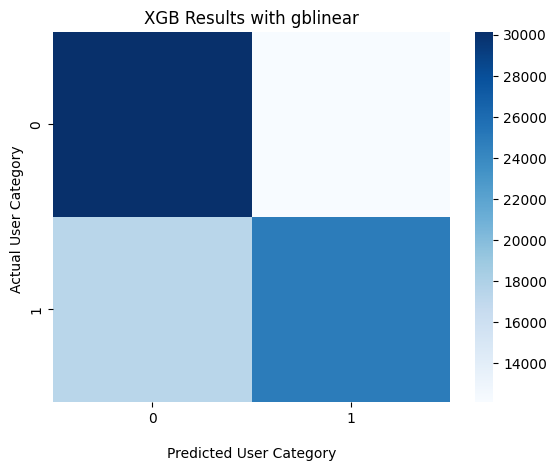

Total Running time = 4.218 seconds  of  gblinear


In [9]:
F1_SCORE= ACCURACY = JaccardScore= RECALL =  PRECISION=0
param = {}
import xgboost as xgb
#param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
param['learning_rate'] = 0.001
param['gpu_id'] = 0
Depth = 5
Boosters=['gbtree','dart', 'gblinear']#'gblinear',
for booster in Boosters:
    print('Executing: ', booster)
    
    param['booster']=booster
    start_time = time.time()
    if booster != 'gblinear':
        param['max_depth'] = Depth
    xgb_model=xgb.XGBClassifier(**param)
    xgb_model.fit(X_train,y_train)
    y_pred_list=xgb_model.predict(X_test)
    X_train_Pred=xgb_model.predict(X_train)
    TrainingResult =accuracy_score(y_train,X_train_Pred)
    TestResult =accuracy_score(y_test,y_pred_list)
    F1_SCORE=f1_score(y_test, y_pred_list)#, average='micro')
    ACCURACY=accuracy_score( y_test, y_pred_list)
    JaccardScore=jaccard_score(y_test, y_pred_list,pos_label=1)
    cfM=confusion_matrix(y_test, y_pred_list)
    RECALL=recall_score(y_test, y_pred_list)#, average='micro')
    PRECISION=precision_score(y_test, y_pred_list)#, average='micro')
    print('Results of : ', booster)
    print('F1_SCORE: ',F1_SCORE,' ACCURACY :',ACCURACY,' JaccardScore :',JaccardScore, ' RECALL :',RECALL, ' PRECISION :',PRECISION)    
    ax = sns.heatmap(cfM, annot=False, cmap='Blues')
    ax.set_title('XGB Results with '+ booster );
    ax.set_xlabel('\nPredicted User Category')
    ax.set_ylabel('Actual User Category ');
    ex_time=time.time() - start_time
    plt.show()
    print("Total Running time = {:.3f} seconds".format(ex_time), " of ",booster)

# DNN

In [10]:
F1_SCORE= ACCURACY = JaccardScore= RECALL =  PRECISION=0
EPOCHS = 1000
BATCH_SIZE = 338230
LEARNING_RATE = 0.01
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train.to_numpy()))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))


In [11]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [12]:
import torch.nn as nn
class BinaryClassification(nn.Module):
    def __init__(self,inputdim):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(inputdim, 900) #1000
        self.layer_2 = nn.Linear(900, 450) 
        self.layer_3 = nn.Linear(450, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(900)
        self.batchnorm2 = nn.BatchNorm1d(450)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        
        x = self.dropout(x)
        x = self.layer_out(x)
        #x = self.relu(x)
        #x = torch.sigmoid(x)
        return x

In [13]:
device = torch.device("cuda:3")#"cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
inputdim=X.shape
print(inputdim)
model = BinaryClassification(int(inputdim[1]))
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


cuda:3
(422788, 19)
BinaryClassification(
  (layer_1): Linear(in_features=19, out_features=900, bias=True)
  (layer_2): Linear(in_features=900, out_features=450, bias=True)
  (layer_3): Linear(in_features=450, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(900, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [14]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

### Train

In [15]:
from tqdm.notebook import tqdm
for i in range(1):
    print("This is times:", i)
    results=(0,0)
    model.train()
    t=1
    with tqdm(total=EPOCHS, desc='(T)') as pbar:
        print(t+1)
        for e in range(1, EPOCHS+1):
        #    print(e)
            epoch_loss = 0
            epoch_acc = 0
            fl=0
            pbar.update()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                y_pred = model(X_batch)                                                           
                loss = criterion(y_pred, y_batch.unsqueeze(1))
                acc = binary_acc(y_pred, y_batch.unsqueeze(1))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                epoch_acc += acc.item()
                if fl==0:
                    savefile=y_pred
                    y_orignal=y_batch.unsqueeze(1)
                    X_orignal=X_batch
                    fl=1
                elif fl==1:
                    savefile=torch.cat((savefile,y_pred))
                    y_orignal=torch.cat((y_orignal,y_batch.unsqueeze(1)))
                    X_orignal=torch.cat((X_orignal,X_batch))

            pbar.set_postfix({'Acc': epoch_acc/len(train_loader)})
            results=(e,epoch_acc/len(train_loader))
            if epoch_acc/len(train_loader)>results[1]+0.1:
                print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
                x_df = pd.DataFrame(X_orignal.cpu().detach().numpy())
                x_df['Orignal']=y_orignal.cpu().detach().numpy()
                x_df['Prediction']=savefile.cpu().detach().numpy()
                if results[1]>95:
                    x_df.to_csv(str(results[1])+' training results.csv')

            if e%50==0:
                print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
                y_pred_list = []
                model.eval()
                pred_prob=[]
                with torch.no_grad():
                    for X_batch in tqdm(test_loader):
                        X_batch = X_batch.to(device)
                        y_test_pred = model(X_batch)

                        y_test_pred = torch.sigmoid(y_test_pred)
                        pred_prob.append(y_test_pred.cpu().numpy()[0])
                        y_pred_tag = torch.round(y_test_pred)
                        y_pred_list.append(y_pred_tag)

                y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
                #print (y_pred_list)
                cfM=confusion_matrix(y_test, y_pred_list)
                from sklearn.metrics import average_precision_score
                average_precision = average_precision_score(y_test, y_pred_list)

                t_F1_SCORE=f1_score(y_test, y_pred_list)#, average='micro')
                t_ACCURACY=accuracy_score( y_test, y_pred_list)
                t_JaccardScore=jaccard_score(y_test, y_pred_list,pos_label=1)            
                t_RECALL=recall_score(y_test, y_pred_list)#, average='micro')
                t_PRECISION=precision_score(y_test, y_pred_list)#, average='micro')
                if F1_SCORE<t_F1_SCORE:
                    F1_SCORE=t_F1_SCORE
                    ACCURACY=t_ACCURACY
                    JaccardScore=t_JaccardScore
                    RECALL=t_RECALL
                    PRECISION=t_PRECISION
                    cf_matrix = confusion_matrix(y_test, y_pred_list)
                    path = "Model/Model.pth"
                    torch.save(model, path)
                    print("Saved Model")
                    print(f'Saved Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
                    print('F1_SCORE: ',F1_SCORE,' ACCURACY :',ACCURACY,' JaccardScore :',JaccardScore, ' RECALL :',RECALL, ' PRECISION :',PRECISION)



This is times: 0


(T):   0%|          | 0/1000 [00:00<?, ?it/s]

2
Epoch 050: | Loss: 0.56042 | Acc: 68.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Saved Model
Saved Epoch 050: | Loss: 0.56042 | Acc: 68.000
F1_SCORE:  0.7374958237525303  ACCURACY : 0.6840748362071004  JaccardScore : 0.5841531755915318  RECALL : 0.8875381376977839  PRECISION : 0.6308481129696563
Epoch 100: | Loss: 0.55461 | Acc: 69.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Epoch 150: | Loss: 0.54916 | Acc: 69.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Epoch 200: | Loss: 0.54650 | Acc: 69.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Saved Model
Saved Epoch 200: | Loss: 0.54650 | Acc: 69.000
F1_SCORE:  0.7399533316048742  ACCURACY : 0.6915963007639726  JaccardScore : 0.5872427983539095  RECALL : 0.8775099926681015  PRECISION : 0.6396786262305822
Epoch 250: | Loss: 0.54260 | Acc: 69.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Epoch 300: | Loss: 0.54118 | Acc: 69.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Epoch 350: | Loss: 0.54055 | Acc: 69.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Epoch 400: | Loss: 0.54061 | Acc: 69.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Epoch 450: | Loss: 0.54095 | Acc: 69.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Saved Model
Saved Epoch 450: | Loss: 0.54095 | Acc: 69.000
F1_SCORE:  0.742729044834308  ACCURACY : 0.6878355684855365  JaccardScore : 0.5907469999069739  RECALL : 0.9011612781154655  PRECISION : 0.631674928297883
Epoch 500: | Loss: 0.54291 | Acc: 70.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Epoch 550: | Loss: 0.53441 | Acc: 70.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Epoch 600: | Loss: 0.53404 | Acc: 70.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Epoch 650: | Loss: 0.53758 | Acc: 70.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Epoch 700: | Loss: 0.53810 | Acc: 70.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Epoch 750: | Loss: 0.53280 | Acc: 70.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Epoch 800: | Loss: 0.53075 | Acc: 70.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Epoch 850: | Loss: 0.53155 | Acc: 70.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Epoch 900: | Loss: 0.52967 | Acc: 70.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Epoch 950: | Loss: 0.52999 | Acc: 70.000


  0%|          | 0/84558 [00:00<?, ?it/s]

Epoch 1000: | Loss: 0.53363 | Acc: 70.000


  0%|          | 0/84558 [00:00<?, ?it/s]

## Test

F1_SCORE:  0.742729044834308  ACCURACY : 0.6878355684855365  JaccardScore : 0.5907469999069739  RECALL : 0.9011612781154655  PRECISION : 0.631674928297883


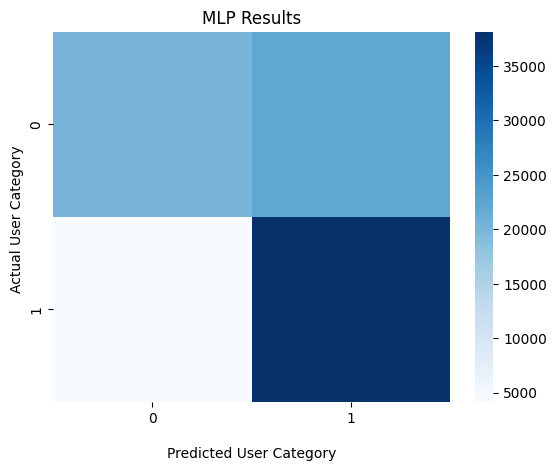

In [16]:
#Model Evalution on Test Data
import torch
import tqdm
F1_SCORE= ACCURACY = JaccardScore= RECALL =  PRECISION=0
path = "Model/Model.pth"
y_pred_list = []
model = torch.load(path)
#model.load_state_dict(torch.load(path))
model.eval()
pred_prob=[]
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        #y_test_pred_prob=y_test_pred
        y_test_pred = torch.sigmoid(y_test_pred)                        
        #pred_prob.append(y_test_pred.cpu().numpy()[0])
        pred_prob.append(y_test_pred.item())                        
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag)

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
#print (y_test_pred_prob)
cfM=confusion_matrix(y_test, y_pred_list)
average_precision = average_precision_score(y_test, y_pred_list)
F1_SCORE=f1_score(y_test, y_pred_list)#, average='micro')
ACCURACY=accuracy_score( y_test, y_pred_list)
JaccardScore=jaccard_score(y_test, y_pred_list,pos_label=1)            
RECALL=recall_score(y_test, y_pred_list)#, average='micro')
PRECISION=precision_score(y_test, y_pred_list)#, average='micro')
print('F1_SCORE: ',F1_SCORE,' ACCURACY :',ACCURACY,' JaccardScore :',JaccardScore, ' RECALL :',RECALL, ' PRECISION :',PRECISION)
ax = sns.heatmap(cfM, annot=False, cmap='Blues')
ax.set_title('MLP Results')
ax.set_xlabel('\nPredicted User Category')
ax.set_ylabel('Actual User Category ');
plt.show()

# SVM 

Executing:  sigmoid
Results of :  sigmoid
F1_SCORE:  0.5900210506397975  ACCURACY : 0.5900210506397975  JaccardScore : 0.4184169910079184  RECALL : 0.5900210506397975  PRECISION : 0.5900210506397975


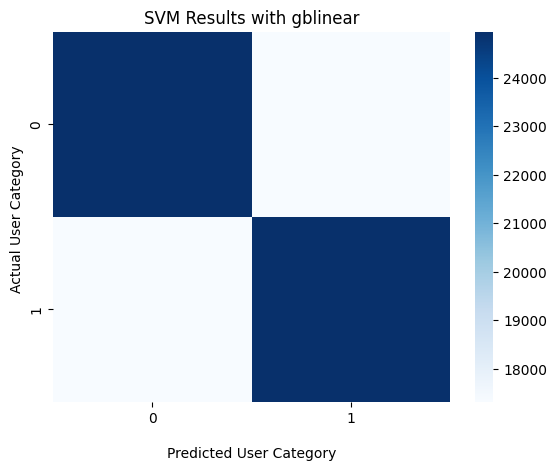

Total Running time = 11064.028 seconds  of  sigmoid
Executing:  poly
Results of :  poly
F1_SCORE:  0.6320277206178008  ACCURACY : 0.6320277206178008  JaccardScore : 0.36747845178077737  RECALL : 0.6320277206178008  PRECISION : 0.6320277206178008


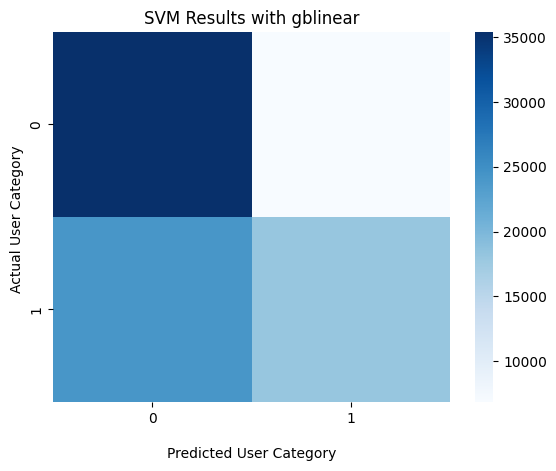

Total Running time = 106129.556 seconds  of  poly
Executing:  linear
Results of :  linear
F1_SCORE:  0.6498852858393056  ACCURACY : 0.6498852858393056  JaccardScore : 0.44960865604491623  RECALL : 0.6498852858393056  PRECISION : 0.6498852858393056


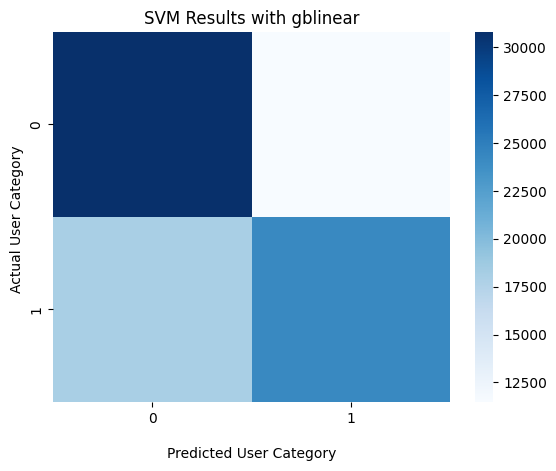

Total Running time = 16656.491 seconds  of  linear
Executing:  rbf
Results of :  rbf
F1_SCORE:  0.6666193618581329  ACCURACY : 0.6666193618581329  JaccardScore : 0.5385496807988214  RECALL : 0.6666193618581329  PRECISION : 0.6666193618581329


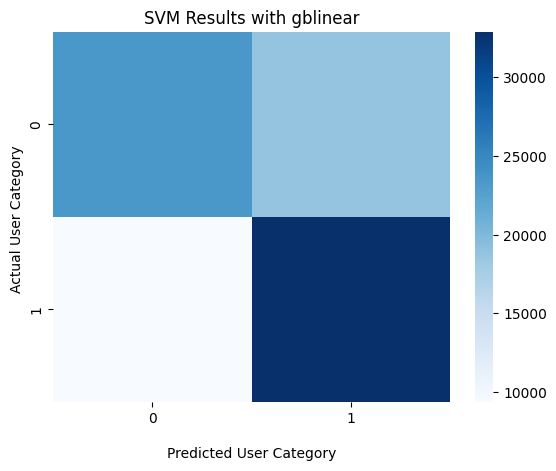

Total Running time = 15593.491 seconds  of  rbf


In [17]:
from sklearn import svm
F1_SCORE= ACCURACY = JaccardScore= RECALL =  PRECISION=0
kernals=['sigmoid' , 'poly','linear', 'rbf'] #,  'poly','linear', 'rbf'
for kernal in kernals:
    print('Executing: ', kernal)
    start_time = time.time()
    KERNAL=kernal
    clf = svm.SVC(kernel=KERNAL)
    clf.fit(X_train, y_train) 
    y_pred_list = clf.predict(X_test)
    X_train_Pred=clf.predict(X_train)
    TrainingResult =accuracy_score(y_train,X_train_Pred)
    TestResult =accuracy_score(y_test,y_pred_list)
    F1_SCORE=f1_score(y_test, y_pred_list, average='micro')
    ACCURACY=accuracy_score( y_test, y_pred_list)
    JaccardScore=jaccard_score(y_test, y_pred_list,pos_label=1)
    cfM=confusion_matrix(y_test, y_pred_list)
    RECALL=recall_score(y_test, y_pred_list, average='micro')
    PRECISION=precision_score(y_test, y_pred_list, average='micro')
    print('Results of : ', kernal)
    print('F1_SCORE: ',F1_SCORE,' ACCURACY :',ACCURACY,' JaccardScore :',JaccardScore, ' RECALL :',RECALL, ' PRECISION :',PRECISION)    
    ax = sns.heatmap(cfM, annot=False, cmap='Blues')
    ax.set_title('SVM Results with '+ kernal );
    ax.set_xlabel('\nPredicted User Category')
    ax.set_ylabel('Actual User Category ');
    ex_time=time.time() - start_time
    plt.show()
    print("Total Running time = {:.3f} seconds".format(ex_time), " of ", kernal)


# Note
Title of Confusion Matrix of SVM has a mistake. 
Titles should contain 'sigmoid' , 'poly','linear', 'rbf' rather than 'gblinear'